# Stream final pipeline - WEBCAM VIDEO
Notebook that process a webcam video in streaming, detecting 2D keypoint coordinates through MediaPipe and inferring the depth through a neural network emulating Martinez et al.neural network architecture

### Imports

!pip install pandas
!pip install mediapipe
!pip install matplotlib
!pip install opencv-python
!pip install --user keras==2.3.1
#h5py == 2.10.0
#tensorflow_estimator==1.15.1


In [1]:
import cv2
import mediapipe as mp
from IPython.display import display, Image, Code, Video
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import keras
import pickle
import time
import tensorflow as tf
import socket

Using TensorFlow backend.


### Socket definition

ip = ""
port = 
msg = 

print(f'Sending {msg} to {ip}:{port}')
sock = socket.socket(socket.AF_INET,
                    socket.sock_DGRAM)
sock.sendto(msg,(ip,port))

### Variables

In [2]:
mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

#Initialize the Mediapipe module with its corresponding parameters
    #model_complexity
    #static_image_mode
    #smooth_landmarks
    #min_detection_confidence
    #min_tracking_confidenced
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(model_complexity=0,min_detection_confidence=0.8,min_tracking_confidence=0.5)

In [3]:
#Path of scaler and nn weights:
model = keras.models.load_model('../models/Final_experiments/2DMP_input_Martinez/Experiment_08/model_30,31.h5')
scaler = pickle.load(open('../models/Final_experiments/2DMP_input_Martinez/Experiment_08/scaler_30,31_mpjpe.pkl','rb'))

#Select the number of keypoints to detect 
number_keypoints_to_detect = 6

#Select the indices of the landmarks of interest to detect from the output of the previous cell
indices_landmark_interest = [11, 12, 13, 14, 15 ,16]

### Functions

In [6]:
def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

#Corregir esta función:

def mediapipe_inference(frame):
    results = pose.process(frame)
    frame_list1 = []
    point_coords_landmark_interest = []
    start_index = 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            #!!!!! If landmark visibility is not 0.5 save a NaN and this value will be replaced by the previous recorded value !!!!
            #Reference & first value is the callibraition picture 
            if start_index in indices_landmark_interest:
                if landmark.visibility>0.8:
                    image_hight, image_width, _ = frame.shape
                    frame = cv2.circle(frame, (int(landmark.x*image_width), int(landmark.y*image_hight)), radius=5, color = (0,255,0), thickness=-1)   
                    frame_list1.append(landmark.x*image_width)
                    frame_list1.append(landmark.y*image_hight)
                    point_coords_landmark_interest.append((int(round(landmark.x*image_width)),int(round(landmark.y*image_hight))))
                    start_index = start_index+1
                else:
                    frame_list1.append(np.NaN)
                    frame_list1.append(np.NaN)
                    start_index = start_index+1
            else: 
                start_index = start_index+1
        try:
            cv2.line(frame,point_coords_landmark_interest[0],point_coords_landmark_interest[2],(255,255,0),thickness=2)
            cv2.line(frame,point_coords_landmark_interest[2],point_coords_landmark_interest[4],(255,0,255),thickness=2)
            cv2.line(frame,point_coords_landmark_interest[1],point_coords_landmark_interest[3],(0,255,255),thickness=2)
            cv2.line(frame,point_coords_landmark_interest[3],point_coords_landmark_interest[5],(255,102,0),thickness=2)
        except:
            pass
    else:
        frame_list1 = np.zeros(number_keypoints_to_detect*2)
        frame_list1[:] = np.nan    
        
    return(frame_list1,frame)
        
def callibration_picture():
    print('A picture will be taken in 1 secs. Please show all your upper body')
    time.sleep(1)
    for i in range(1,2):
        cap1 = cv2.VideoCapture(0)
        success, frame1 = cap1.read()
        frame1 = cv2.resize(frame1,(1920,1080))
        cap1.release()
    return(frame1)

### Take a calibration picture 

A picture will be taken in 1 secs. Please show all your upper body
Joints have not been detected properly - Another picture will be taken 

A picture will be taken in 1 secs. Please show all your upper body
Joints have not been detected properly - Another picture will be taken 

A picture will be taken in 1 secs. Please show all your upper body


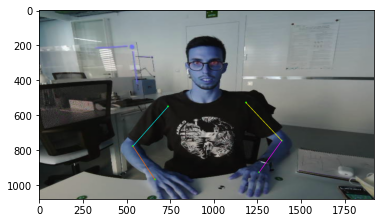

In [7]:
frame = callibration_picture()
detected_keypoints, frame = mediapipe_inference(frame)

while pd.DataFrame(detected_keypoints).T.isna().sum().sum()>= 1 or len(detected_keypoints) == 0: 
    print('Joints have not been detected properly - Another picture will be taken \n')
    frame = callibration_picture()
    detected_keypoints,frame = mediapipe_inference(frame)
    
plt.imshow(frame)

### Check output

In [8]:
df_2D = pd.DataFrame(columns=np.arange(0,12))
df_2D = df_2D.append(pd.DataFrame(detected_keypoints).T)
df_2D= df_2D[[2,3,6,7,10,11,0,1,4,5,8,9]]
detected_keypoints = np.array(df_2D.iloc[0]).reshape(1,-1)
X_scaled = scaler.transform(detected_keypoints)
z_predicted = model.predict(X_scaled)
df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted))

In [9]:
df_2D

,2,3,6,7,10,11,0,1,4,5,8,9
0,739.223843,550.774949,537.877293,777.396355,664.023514,967.540791,1186.119232,528.704789,1391.124458,746.440852,1261.027679,926.61056


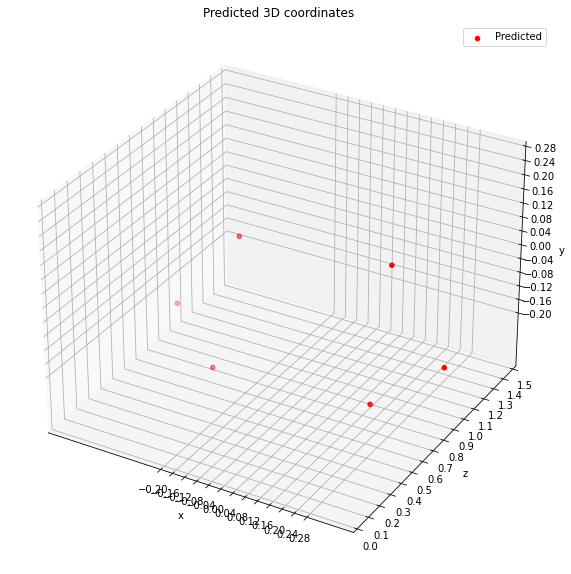

In [10]:
x_line = []
y_line = []
z_line = []

for keypoint in list(df_pred_3d.iloc[0]):
    x_line.append(keypoint[0])
    y_line.append(keypoint[1])
    z_line.append(keypoint[2])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_line, z_line,y_line,c='red',label='Predicted')

ax.set_xlabel('x')
ax.set_xticks(np.arange(-0.2,0.3,0.04))

ax.set_ylabel('z')
ax.set_yticks(np.arange(0,1.6,0.1))

ax.set_zlabel('y')
ax.set_zticks(np.arange(-0.2,0.3,0.04))

ax.set_title('Predicted 3D coordinates')
ax.legend()

In [11]:
df = df_2D

### Video stream pipeline

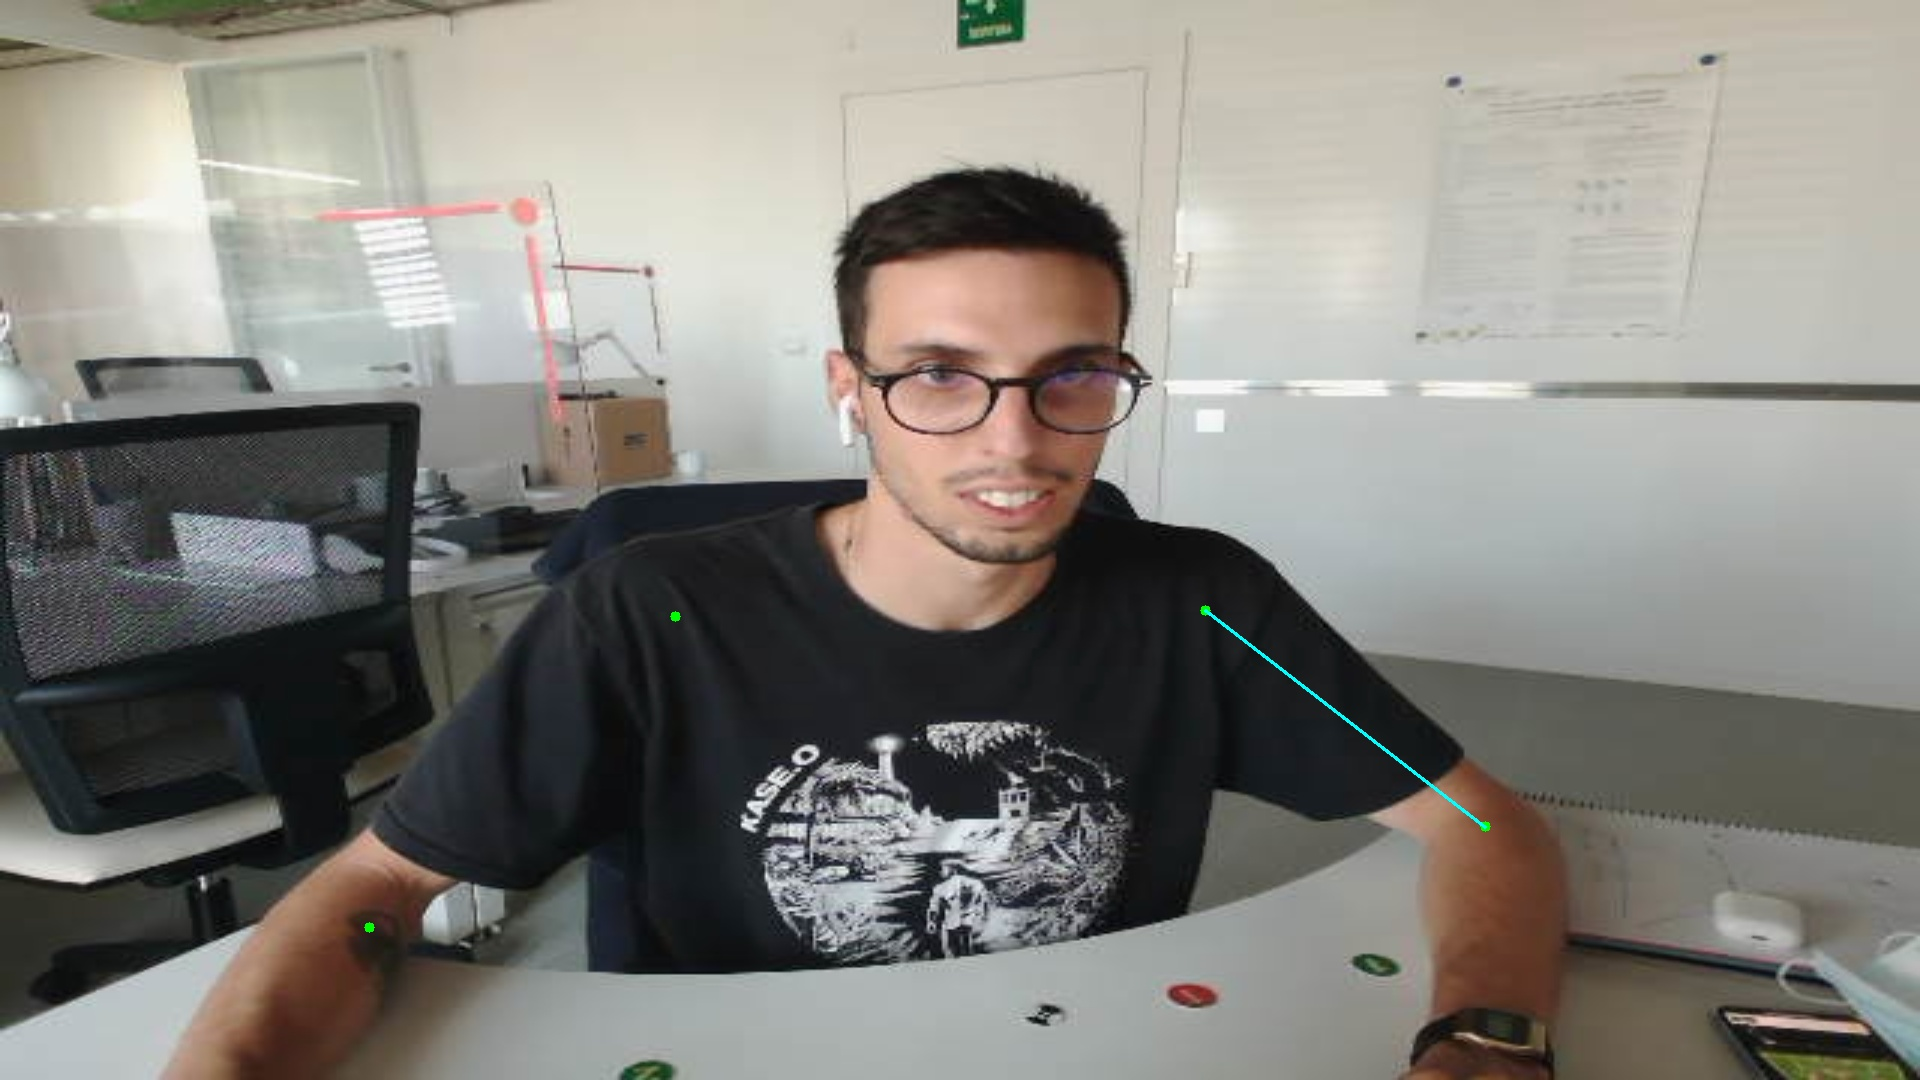

0  \
0  [-0.5055864, -0.07168971, 1.0022963]   

                                       1  \
0  [-0.81301254, -0.39468154, 0.9380451]   

                                       2  \
0  [-0.61692756, -0.24442036, 1.0034943]   

                                       3                                   4  \
0  [0.07499987, -0.072241746, 1.0939355]  [0.41084668, -0.338869, 1.1927738]   

                                      5  
0  [0.03463918, -0.24612585, 1.0699046]

Camera is closed


In [12]:
#Display a Python object in all frontends --> Similar to using print() in terminal
display_handle=display(None, display_id=True)
display_handle2=display(None, display_id=True)

#Frame number - 0 is the callibration picture, the following the detected webcam frames
n = 0

mp_time = []
nn_time = []

#Initialize stream capture
cap = cv2.VideoCapture(0)

try: 
    while cap.isOpened():
        n = n+1
        
        #Success = True --> Video have been read. Frame --> 3D array containing the image frame information
        sucess,frame = cap.read()
        frame = cv2.resize(frame,(1920,1080))
        
        start1 = time.time()
        
        #MediaPipe inference
        detected_keypoints, frame = mediapipe_inference(frame)
        
        if len(detected_keypoints) < (number_keypoints_to_detect*2):
            detected_keypoints = list(df.iloc[n-1])
        else:
            pass
            
        df = df.append(pd.DataFrame(detected_keypoints).T)
        df = df[[2,3,6,7,10,11,0,1,4,5,8,9]]
        df = df.fillna(method='ffill')
        
        end1 = time.time()
        mp_time.append(end1-start1)
        
    

        if all(isinstance(n,float) for n in list(df.iloc[n])) == True:

            #NEURAL NETWORK INFERENCE
            start2 = time.time()

            X = np.array([list(df.iloc[n])]).astype(float)

            X_scaled = scaler.transform(X)
            z_predicted = model.predict(X_scaled)
            df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted))

            end2 = time.time()
            nn_time.append(end2-start2)


            display_handle2.update(Code(data=str(df_pred_3d)))

            success, frame = cv2.imencode('.jpeg',frame)
            display_handle.update(Image(data=frame.tobytes()))


except KeyboardInterrupt:
    print('Camera is closed')
    cap.release()

In [16]:
list(df.iloc[25])

[837.2158813476562,
 491.9909906387329,
 746.3387489318848,
 700.0472831726074,
 711.0642242431641,
 904.9832224845886,
 1150.2810287475586,
 494.8377585411072,
 1242.6506423950195,
 708.0081009864807,
 1235.4217529296875,
 904.3652415275574]

In [12]:
number_keypoints_to_detect*2

12

In [11]:
detected_keypoints

[]

In [12]:
ms_nn_time = []
for value in nn_time:
    ms_nn_time.append(value*1000)
print(sum(ms_nn_time)/len(ms_nn_time))

ms_mp_time = []
for value in mp_time:
    ms_mp_time.append(value*1000)
    
print(sum(ms_mp_time)/len(ms_mp_time))

2.6526809635018944
21.613282943839458


In [10]:
df_pred_3d

,0,1,2,3,4,5
0,"[0.47103754, 0.53224075, 2.2026603]","[0.116236255, 0.46225324, 1.7724388]","[0.310131, 0.33217272, 1.9264734]","[0.18721884, 0.5149895, 2.354484]","[0.37522498, 0.5216906, 2.3946688]","[-0.32445568, 0.566213, 2.9147549]"
